## scikit-learn搜索超参数

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.14.5
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

# 默认划分比例为3:1
X_train_all, X_test, y_train_all, y_test = train_test_split(housing.data, housing.target,
                                                           random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all,
                                                     random_state=11)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 使用Randomized Search 
# 1.将模型转换为sklearn格式   
# 2.定义超参数集合 
# 3.搜索参数

def build_model(hidden_layers=1,
                layer_size=30,
                learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, 
                                activation='relu',
                                input_shape=X_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                    activation='relu'))
    model.add(keras.layers.Dense(1))
    opt = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

sk_model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
log_his = sk_model.fit(X_train_scaled, y_train,
             epochs=10,
             validation_data=(X_valid_scaled, y_valid),
             callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 38us/sample - loss: 1.3298 - val_loss: 0.8216
Epoch 2/10
11610/11610 [==============================] - 0s 24us/sample - loss: 0.7565 - val_loss: 0.7288
Epoch 3/10
11610/11610 [==============================] - 0s 25us/sample - loss: 0.6331 - val_loss: 0.6644
Epoch 4/10
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5858 - val_loss: 0.6159
Epoch 5/10
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5573 - val_loss: 0.5854
Epoch 6/10
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5259 - val_loss: 0.5501
Epoch 7/10
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5079 - val_loss: 0.5341
Epoch 8/10
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4924 - val_loss: 0.5178
Epoch 9/10
11610/11610 [==============================] - 0s 24us/sample - loss: 0.4834 - val_l

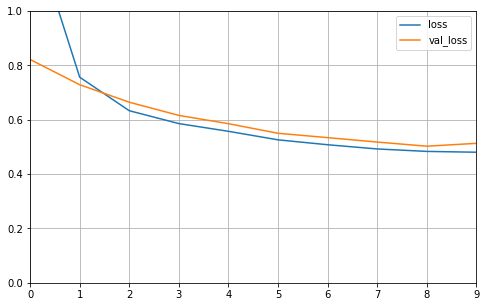

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(log_his)

In [16]:
# 定义超参数集合
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

params_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size" : np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

# n_iters表示共组成多少组超参数
# cv表示cross validation时划分数据集份数
random_search_cv = RandomizedSearchCV(sk_model,
                                      params_distribution,
                                      n_iter=10,
                                      cv=3,
                                      n_jobs=1)

random_search_cv.fit(X_train_scaled, y_train,
                     epochs=100,
                     validation_data=(X_valid_scaled, y_valid),
                     callbacks=callbacks)

/Users/barackbao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 46us/sample - loss: 1.7903 - val_loss: 0.7266
Epoch 2/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6514 - val_loss: 0.6545
Epoch 3/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6058 - val_loss: 0.6136
Epoch 4/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5661 - val_loss: 0.5851
Epoch 5/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5394 - val_loss: 0.5571
Epoch 6/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5257 - val_loss: 0.5385
Epoch 7/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5045 - val_loss: 0.5213
Epoch 8/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4916 - val_loss: 0.5079
Epoch 9/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4829 - val_loss: 0.497

7740/7740 [==============================] - 0s 26us/sample - loss: 0.4919 - val_loss: 0.5326
Epoch 9/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4864 - val_loss: 0.5214
Epoch 10/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4733 - val_loss: 0.5141
Epoch 11/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4634 - val_loss: 0.5072
Epoch 12/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4564 - val_loss: 0.4971
Epoch 13/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4479 - val_loss: 0.4878
Epoch 14/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4461 - val_loss: 0.4827
Epoch 15/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4437 - val_loss: 0.4806
Epoch 16/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4366 - val_loss: 0.4744
Epoch 17/100
7740/7740 [===========================

3870/3870 [==============================] - 0s 10us/sample - loss: 0.4653
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 43us/sample - loss: 4.2266 - val_loss: 3.1623
Epoch 2/100
7740/7740 [==============================] - 0s 30us/sample - loss: 2.5279 - val_loss: 2.1371
Epoch 3/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.7666 - val_loss: 1.6082
Epoch 4/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.3553 - val_loss: 1.2924
Epoch 5/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.1065 - val_loss: 1.0968
Epoch 6/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.9570 - val_loss: 0.9769
Epoch 7/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.8674 - val_loss: 0.9020
Epoch 8/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.8121 - val_loss: 0.8534
Epoch 9/100
7740/7740 [======

7740/7740 [==============================] - 0s 26us/sample - loss: 0.6092 - val_loss: 0.6755
Epoch 12/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5962 - val_loss: 0.6627
Epoch 13/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5849 - val_loss: 0.6513
Epoch 14/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5751 - val_loss: 0.6411
Epoch 15/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5663 - val_loss: 0.6320
Epoch 16/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5585 - val_loss: 0.6236
Epoch 17/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5516 - val_loss: 0.6162
Epoch 18/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5453 - val_loss: 0.6095
Epoch 19/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5397 - val_loss: 0.6033
Epoch 20/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 26us/sample - loss: 0.4896 - val_loss: 0.5044
Epoch 40/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4864 - val_loss: 0.5007
Epoch 41/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4835 - val_loss: 0.4974
Epoch 42/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4808 - val_loss: 0.4944
Epoch 43/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4785 - val_loss: 0.4911
Epoch 44/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4761 - val_loss: 0.4886
Epoch 45/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4741 - val_loss: 0.4863
Epoch 46/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4719 - val_loss: 0.4836
Epoch 47/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4702 - val_loss: 0.4814
Epoch 48/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 25us/sample - loss: 0.5542 - val_loss: 0.6093
Epoch 24/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.5501 - val_loss: 0.6049
Epoch 25/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5458 - val_loss: 0.6009
Epoch 26/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5412 - val_loss: 0.5960
Epoch 27/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5377 - val_loss: 0.5914
Epoch 28/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5334 - val_loss: 0.5867
Epoch 29/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5303 - val_loss: 0.5838
Epoch 30/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5269 - val_loss: 0.5788
Epoch 31/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5237 - val_loss: 0.5756
Epoch 32/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 35us/sample - loss: 0.4694 - val_loss: 0.4834
Epoch 47/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4662 - val_loss: 0.4799
Epoch 48/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4629 - val_loss: 0.4770
Epoch 49/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4601 - val_loss: 0.4734
Epoch 50/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4570 - val_loss: 0.4707
Epoch 51/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4540 - val_loss: 0.4675
Epoch 52/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4516 - val_loss: 0.4647
Epoch 53/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4489 - val_loss: 0.4618
Epoch 54/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4464 - val_loss: 0.4594
Epoch 55/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 37us/sample - loss: 0.4309 - val_loss: 0.4581
Epoch 57/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4290 - val_loss: 0.4559
Epoch 58/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4271 - val_loss: 0.4538
Epoch 59/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4252 - val_loss: 0.4523
Epoch 60/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4234 - val_loss: 0.4504
Epoch 61/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4215 - val_loss: 0.4489
Epoch 62/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4201 - val_loss: 0.4457
Epoch 63/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4183 - val_loss: 0.4436
Epoch 64/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4167 - val_loss: 0.4416
Epoch 65/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 32us/sample - loss: 0.4112 - val_loss: 0.4530
Epoch 64/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4096 - val_loss: 0.4514
Epoch 65/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4081 - val_loss: 0.4496
Epoch 66/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4064 - val_loss: 0.4480
Epoch 67/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4049 - val_loss: 0.4467
Epoch 68/100
3870/3870 [==============================] - 0s 12us/sample - loss: 0.4518
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.8945 - val_loss: 0.5828
Epoch 2/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.5272 - val_loss: 0.4836
Epoch 3/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4437 - val_loss: 0.4274
Epoch 4/100
7740/7740 [=

7740/7740 [==============================] - 0s 42us/sample - loss: 0.3099 - val_loss: 0.3417
Epoch 18/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3087 - val_loss: 0.3337
Epoch 19/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3015 - val_loss: 0.3329
Epoch 20/100
3870/3870 [==============================] - 0s 11us/sample - loss: 0.3435
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 61us/sample - loss: 5.3926 - val_loss: 4.5221
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 3.5519 - val_loss: 2.9799
Epoch 3/100
7740/7740 [==============================] - 0s 33us/sample - loss: 2.2831 - val_loss: 1.8898
Epoch 4/100
7740/7740 [==============================] - 0s 33us/sample - loss: 1.4869 - val_loss: 1.3165
Epoch 5/100
7740/7740 [==============================] - 0s 42us/sample - loss: 1.1336 - val_loss: 1.1051
Epoch 6/100
7740/7740 [===

7740/7740 [==============================] - 0s 32us/sample - loss: 0.5107 - val_loss: 0.5357
Epoch 73/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5088 - val_loss: 0.5339
Epoch 74/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5070 - val_loss: 0.5319
Epoch 75/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5052 - val_loss: 0.5299
Epoch 76/100
3870/3870 [==============================] - 0s 11us/sample - loss: 0.4704
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 55us/sample - loss: 4.5775 - val_loss: 4.0887
Epoch 2/100
7740/7740 [==============================] - 0s 33us/sample - loss: 3.3403 - val_loss: 2.9680
Epoch 3/100
7740/7740 [==============================] - 0s 32us/sample - loss: 2.4031 - val_loss: 2.1635
Epoch 4/100
7740/7740 [==============================] - 0s 32us/sample - loss: 1.8050 - val_loss: 1.7100
Epoch 5/100
7740/7740 [==

7740/7740 [==============================] - 0s 31us/sample - loss: 0.8597 - val_loss: 0.8757
Epoch 7/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.8144 - val_loss: 0.8407
Epoch 8/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7812 - val_loss: 0.8139
Epoch 9/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.7555 - val_loss: 0.7932
Epoch 10/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7351 - val_loss: 0.7767
Epoch 11/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7181 - val_loss: 0.7633
Epoch 12/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7039 - val_loss: 0.7520
Epoch 13/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6918 - val_loss: 0.7423
Epoch 14/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6812 - val_loss: 0.7339
Epoch 15/100
7740/7740 [=============================

7740/7740 [==============================] - 0s 36us/sample - loss: 0.4177 - val_loss: 0.4307
Epoch 10/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4063 - val_loss: 0.4203
Epoch 11/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3980 - val_loss: 0.4093
Epoch 12/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3905 - val_loss: 0.4031
Epoch 13/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3826 - val_loss: 0.3965
Epoch 14/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3773 - val_loss: 0.3943
Epoch 15/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3715 - val_loss: 0.3881
Epoch 16/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3670 - val_loss: 0.3812
Epoch 17/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3627 - val_loss: 0.3774
Epoch 18/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 35us/sample - loss: 0.3333 - val_loss: 0.3690
Epoch 27/100
3870/3870 [==============================] - 0s 12us/sample - loss: 0.3803
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 49us/sample - loss: 5.4581 - val_loss: 3.9535
Epoch 2/100
7740/7740 [==============================] - 0s 29us/sample - loss: 2.9488 - val_loss: 2.5244
Epoch 3/100
7740/7740 [==============================] - 0s 28us/sample - loss: 2.1129 - val_loss: 1.9629
Epoch 4/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.7398 - val_loss: 1.6803
Epoch 5/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.5299 - val_loss: 1.5121
Epoch 6/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.3929 - val_loss: 1.3942
Epoch 7/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.2950 - val_loss: 1.3085
Epoch 8/100
7740/7740 [=====

7740/7740 [==============================] - 0s 27us/sample - loss: 3.0404 - val_loss: 2.5778
Epoch 3/100
7740/7740 [==============================] - 0s 27us/sample - loss: 2.0977 - val_loss: 1.8991
Epoch 4/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.6136 - val_loss: 1.5364
Epoch 5/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.3491 - val_loss: 1.3276
Epoch 6/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.1910 - val_loss: 1.1950
Epoch 7/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.0868 - val_loss: 1.1022
Epoch 8/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.0121 - val_loss: 1.0338
Epoch 9/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.9575 - val_loss: 0.9813
Epoch 10/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.9138 - val_loss: 0.9398
Epoch 11/100
7740/7740 [==============================] -

7740/7740 [==============================] - 0s 28us/sample - loss: 2.9355 - val_loss: 2.6061
Epoch 3/100
7740/7740 [==============================] - 0s 27us/sample - loss: 2.1258 - val_loss: 1.9717
Epoch 4/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.6544 - val_loss: 1.6146
Epoch 5/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.3754 - val_loss: 1.4036
Epoch 6/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.1950 - val_loss: 1.2621
Epoch 7/100
7740/7740 [==============================] - 0s 27us/sample - loss: 1.0687 - val_loss: 1.1567
Epoch 8/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.9702 - val_loss: 1.0715
Epoch 9/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.8927 - val_loss: 1.0018
Epoch 10/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.8319 - val_loss: 0.9445
Epoch 11/100
7740/7740 [==============================] -

7740/7740 [==============================] - 0s 30us/sample - loss: 0.4194 - val_loss: 0.4370
Epoch 26/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4157 - val_loss: 0.4350
Epoch 27/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4129 - val_loss: 0.4319
Epoch 28/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4089 - val_loss: 0.4262
Epoch 29/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4069 - val_loss: 0.4227
Epoch 30/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4032 - val_loss: 0.4203
Epoch 31/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4013 - val_loss: 0.4168
Epoch 32/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3976 - val_loss: 0.4143
Epoch 33/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3957 - val_loss: 0.4126
Epoch 34/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 32us/sample - loss: 0.4782 - val_loss: 0.5233
Epoch 20/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4682 - val_loss: 0.5144
Epoch 21/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4586 - val_loss: 0.5023
Epoch 22/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4504 - val_loss: 0.4922
Epoch 23/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4415 - val_loss: 0.4843
Epoch 24/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4340 - val_loss: 0.4732
Epoch 25/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4260 - val_loss: 0.4660
Epoch 26/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4193 - val_loss: 0.4593
Epoch 27/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4138 - val_loss: 0.4524
Epoch 28/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 30us/sample - loss: 0.4822 - val_loss: 0.5117
Epoch 53/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4804 - val_loss: 0.5093
Epoch 54/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4786 - val_loss: 0.5079
Epoch 55/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4767 - val_loss: 0.5059
Epoch 56/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4749 - val_loss: 0.5043
Epoch 57/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4731 - val_loss: 0.5032
Epoch 58/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4715 - val_loss: 0.5008
Epoch 59/100
3870/3870 [==============================] - 0s 14us/sample - loss: 0.4444
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 56us/sample - loss: 3.7735 - val_loss: 2.8377
Epoch 2/100
7740/7740 

7740/7740 [==============================] - 0s 31us/sample - loss: 0.4826 - val_loss: 0.5165
Epoch 69/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4804 - val_loss: 0.5141
Epoch 70/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4783 - val_loss: 0.5118
Epoch 71/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4762 - val_loss: 0.5096
Epoch 72/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4741 - val_loss: 0.5074
Epoch 73/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4722 - val_loss: 0.5054
Epoch 74/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4704 - val_loss: 0.5033
Epoch 75/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4685 - val_loss: 0.5011
Epoch 76/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4667 - val_loss: 0.4992
Epoch 77/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 30us/sample - loss: 0.4712 - val_loss: 0.5241
Epoch 62/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4697 - val_loss: 0.5220
Epoch 63/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4680 - val_loss: 0.5201
Epoch 64/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4664 - val_loss: 0.5184
Epoch 65/100
3870/3870 [==============================] - 0s 11us/sample - loss: 0.5116
Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.8878 - val_loss: 0.5242
Epoch 2/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4512 - val_loss: 0.4602
Epoch 3/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4101 - val_loss: 0.4236
Epoch 4/100
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3855 - val_loss: 0.4163
Epoch 5/100
1161

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x13579f588>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 3...45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13560e1d0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train

In [17]:
# 获取超参数搜索后的结果
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 41, 'learning_rate': 0.008941881034695053}
-0.3161459981881782


In [18]:
# 查看最优超参数集合的模型效果
best_model = random_search_cv.best_estimator_.model
best_model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 20us/sample - loss: 0.3215


0.3215030896109204